
<center><font size="+3">
Data Analysis and Machine Learning   
    
<center><font size="+2">    
Continuous Assessment 2     
<center>    
Jim Coen   
<center>    
Student Number: 10556748  
</font></center>


# Linear Regression

> <span style="color:darkblue">Primary Research Question:</span>  
> What subset of features account for most of the variance in the outcome variable.


## Justification for the 'candy-power-ranking' dataset  
(Hickey, 2017)  

* The dataset has a clearly defined outcome variable, _winpercent_.  Also, authors obtained the respones of almost 270,000 customers of candy bars in order to calculate overall _winpercent_ for each bar.  In addition, this target variable is numeric so it is feasible to perform regression on it.

* While there are only 85 observations, typically this is the case for commercial products where there a limited number of offerings in any given market segment.

* Many commercial products can be described in terms of a combination of continuous and binary variables.  In this way, observations record both the physical properties (dimension, capacity) and whether or not the product has particular capabilities.  

* This type of dataset has even broader application.  For instance, a hospital measures vital signs such as the levels of blood components along with a series of binary responses on the medical history of the patient.  

## Justification for the Analysis Method

* Linear regression is especially useful for continuous variables but it can be adapted to accomodate binary variables also. 

* Linear models can assess the effect of changing the ingredients on the target variable, which is the approval rating.

* Multiple Linear Regression gives the impact of each of the explanatory variables on the response while holding the other variables constant.

* Clustering offers the possibility of identifying types of products.  This would enable a new entrant into the market to differentiate their new product from existing ones.

## Exploratory Data Analysis

Initialisation

In [1]:
import pandas as pd
import numpy as np
print("Pandas version:", pd.__version__)
print("Numpy version:", np.__version__)
# various options in pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 25)
pd.set_option('display.precision', 3)

import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

import scipy  # stats functions
import statsmodels

Pandas version: 1.0.5
Numpy version: 1.18.5


_Candy Power Ranking_ dataset from __fivethirtyeight.com__

In [53]:
# abrieviate long column names for ease of reference
cols =  ['brand', 'choc', 'fruit', 'caramel', 'nuty', 'nougat', 'crisp', 'hard', 'bar', 'plur', 'sugarpc', 'pricepc', 'winpc']

df= pd.read_csv(
    'https://raw.githubusercontent.com/fivethirtyeight/data/master/candy-power-ranking/candy-data.csv',
    header = None,
    names = cols
)

In [54]:
df.head(5)

,brand,choc,fruit,caramel,nuty,nougat,crisp,hard,bar,plur,sugarpc,pricepc,winpc
0,competitorname,chocolate,fruity,caramel,peanutyalmondy,nougat,crispedricewafer,hard,bar,pluribus,sugarpercent,pricepercent,winpercent
1,100 Grand,1,0,1,0,0,1,0,1,0,.73199999,.86000001,66.971725
2,3 Musketeers,1,0,0,0,1,0,0,1,0,.60399997,.51099998,67.602936
3,One dime,0,0,0,0,0,0,0,0,0,.011,.116,32.261086
4,One quarter,0,0,0,0,0,0,0,0,0,.011,.51099998,46.116505


__Data Cleaning__


In [55]:
df = df.drop(df.index[[0]])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 85 entries, 1 to 85
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   brand    85 non-null     object
 1   choc     85 non-null     object
 2   fruit    85 non-null     object
 3   caramel  85 non-null     object
 4   nuty     85 non-null     object
 5   nougat   85 non-null     object
 6   crisp    85 non-null     object
 7   hard     85 non-null     object
 8   bar      85 non-null     object
 9   plur     85 non-null     object
 10  sugarpc  85 non-null     object
 11  pricepc  85 non-null     object
 12  winpc    85 non-null     object
dtypes: object(13)
memory usage: 9.3+ KB


In [56]:
df['sugarpc'] = df['sugarpc'].astype(float).round(9)
df['pricepc'] = df['pricepc'].astype(float).round(9)
df['winpc'] = df['winpc'].astype(float).round(9)
cols_bin = ['choc', 'fruit', 'caramel', 'nuty', 'nougat', 'crisp', 'hard', 'bar', 'plur']
df[cols_bin] = df[cols_bin].astype('int')
df['brand'] = df['brand'].astype('str')

print(df.dtypes) 

brand       object
choc         int64
fruit        int64
caramel      int64
nuty         int64
nougat       int64
crisp        int64
hard         int64
bar          int64
plur         int64
sugarpc    float64
pricepc    float64
winpc      float64
dtype: object


__Inspect the Data__

The dataset has 85 observations referring to each brand in the survey and there are no null values.  However, this dataset is out of step with the sampling recommendation for regression, which would require 240 (20 x 12) measurements.

* _winpc_  
    Candy bar aficionados were asked to compare two bars.  There were 269,000 of these matchups that were generated randomly.  A person gave their preference from among the two bars selected.  The _winpc_ variable refers to the percentage of times a particular bar 'won' in a matchup with another bar.
    
* _sugarpc_  
    The percentile of sugar content that a candy bar falls under.
    
* _pricepc_  
    The unit price percentile compared to the rest of the data.
   
* Binary variables  
    Whether or not a candy bar contains a particular ingredient

__Check for Collinearity__

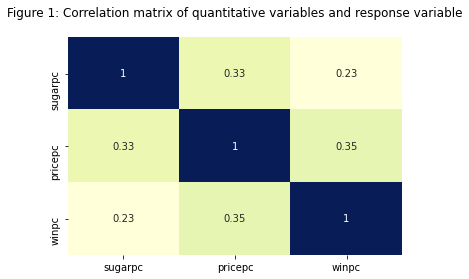

In [57]:
# df['sugarpc'].corr(df['pricepc']).round(5)

# select the three 'float' columns
df_float = df.iloc[:,10:13]

correlation_mat = df_float.corr()

sns.heatmap(correlation_mat, cmap="YlGnBu", annot=True, cbar=False)
plt.title("Figure 1: Correlation matrix of quantitative variables and response variable\n")
plt.show()

=> There low correlation between the two explanatory variables.   
However, there is also low correlation with the response variable.  This fails to meet linearity assumption for Linear Regression.

Confirmation of lack of association between _pricepc_, _sugarpc_ and _winpc_: 

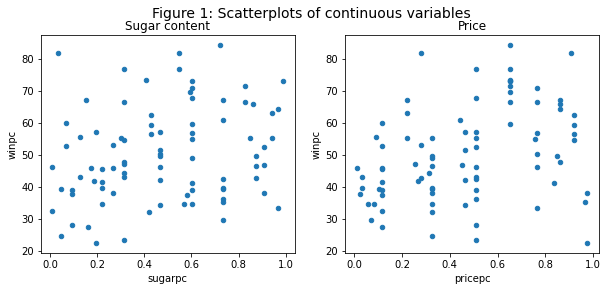

In [7]:
fig1, ax1 = plt.subplots(nrows=1, ncols=2)
fig1.set_size_inches(10, 4)
plt.subplots_adjust(wspace=0.2)
    
df.plot.scatter( x='sugarpc', y='winpc', ax=ax1[0], title="Sugar content")
ax1[0].set_xlabel('sugarpc')
ax1[0].set_ylabel('winpc')

df.plot.scatter(x='pricepc', y='winpc', ax=ax1[1], title="Price")
ax1[1].set_xlabel('pricepc')
ax1[1].set_ylabel('winpc')
    
fig1.suptitle('Figure 1: Scatterplots of continuous variables\n', fontsize=14)
#plt.title('Figure 1: Scatterplots of continuous variables\n', fontsize=16)

plt.show()

=> only the binary variables are available for regression.

In [8]:
df = df.drop(columns=['sugarpc', 'pricepc'])

# Column indices
col_mapping = [f"{c[0]}:{c[1]}" for c in enumerate(df.columns)]
col_mapping

['0:brand',
 '1:choc',
 '2:fruit',
 '3:caramel',
 '4:nuty',
 '5:nougat',
 '6:crisp',
 '7:hard',
 '8:bar',
 '9:plur',
 '10:winpc']

__Inspect Binary Variables__  
From a random selection of two out of the 10 binary variables, carry out a test for independence on those two categorical variables.

In [9]:
import random
random.seed(21)
binary_vars = df.iloc[:, 0:9].columns.values.tolist()
s  = random.sample(binary_vars, 2)
ct = pd.crosstab( df[s[0]], df[s[1]])
obs = np.array([ct.iloc[0][0:1].values,
                  ct.iloc[1][0:1].values])
scipy.stats.chi2_contingency(obs)[0:3]

(0.0, 1.0, 0)

=> needs further interpretation   
see: https://towardsdatascience.com/chi-square-test-for-independence-in-python-with-examples-from-the-ibm-hr-analytics-dataset-97b9ec9bb80a  
by Dehao Zhang

## Simple Linear Regression

__Assumptions for Linear Regression__  
(Simple Linear Regression, 2016)

1. **Linearity:** The association between the expanatory variables and the response needs to be linear.  
2. **Homoscedasity:**  The variance in the residuals needs to be constant across all values of the observed response/outcome variable.  
3. **Normality:**  Residuals need to have a normal distribution.  
4. **Independence:**  The explanatory variables need to be independent of each other (no collinearity).  

**Sampling:** In addition, it is recommended that there are 20 observations for each explanatory variable in the dataset (Assumptions of Linear Regression, 2021).


### Linear Model for Binary Variables - Proof of Concept

__Linear Models in Practice__   
The following analysis follows the procedure given in the course __Linear Models and Matrix Algebra__ (Irizarry, 2018) applied to the _Candy Bar Ranking_ dataset.  In addition, the implementation is different since the code for the source was in `R`.


In [10]:
c0 = df.loc[df.choc == 0, 'winpc'].mean()
c1 = df.loc[df.choc == 1, 'winpc'].mean()

print("mean without choc: {:.3f}".format(c0))
print("mean with choc: {:.3f}".format(c1))
print("difference in means: {:.3f}".format(c1 - c0))

mean without choc: 42.142
mean with choc: 60.922
difference in means: 18.779


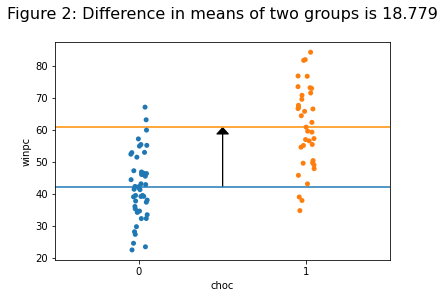

In [11]:
choc_df = df[['choc','winpc']]

fig2 = sns.stripplot(x="choc", y="winpc", data=choc_df, jitter=0.05)

fig2.axhline(42.142)
fig2.axhline(60.922, color='darkorange')

# # P.arrow( x, y, dx, dy, **kwargs )
fig2.arrow( 0.5, 42.142, 0.0, +16.5, 
            fc="k", ec="k", head_width=0.07, head_length=2 )

plt.title('Figure 2: Difference in means of two groups is 18.779\n', fontsize=16)

plt.show()

Note that '0' is the reference level.

__Regression with `linregress`__  

b: This is the slope of the regression line
a: This is the intercept of the regression line
r: This is the correlation coefficient
p: This is the two-sided p-value for the hypotheses test-for the null hypothesis that assumes the slope is zero i.e. no association between variables
stderr: This is the standard error of the estimate

In [12]:
from scipy.stats import linregress, ttest_ind 
choc_m = df[['choc','winpc']]
b, a, r, p, stderr = linregress(choc_m) 

print("Intercept: {:.3f}".format(a))
print("Slope: {:.3f}".format(b))
print("Correlation coeff: {:.3f}".format(r))
print("R-squared: {:.3f}".format(r**2))
print("std-err: {:.3f}".format(stderr))


Intercept: 42.142
Slope: 18.779
Correlation coeff: 0.637
R-squared: 0.405
std-err: 2.498


__Regression with `ols` from `statsmodels`__

In [13]:
from statsmodels.formula.api import ols

model = ols("winpc ~ choc", 
            df).fit()

# Print the summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  winpc   R-squared:                       0.405
Model:                            OLS   Adj. R-squared:                  0.398
Method:                 Least Squares   F-statistic:                     56.53
Date:                Fri, 15 Jan 2021   Prob (F-statistic):           5.86e-11
Time:                        09:12:45   Log-Likelihood:                -326.58
No. Observations:                  85   AIC:                             657.2
Df Residuals:                      83   BIC:                             662.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     42.1423      1.648     25.574      0.0

The interpretation of Linear Regression with a binary predictor is that the intercept gives the mean of the reference level.  The second coefficient gives the difference in the means of the two groups (with and without chocolate).

In [14]:
from scipy import stats

print('Counts for two choc groups: ')
print( df.choc.value_counts())

choc_0 = df.loc[df.choc == 0, 'winpc']
choc_1 = df.loc[df.choc == 1, 'winpc']

t_stat, p_value = stats.ttest_ind(choc_1, choc_0, equal_var=True)
print("\nt statistic: {:.5f}".format(t_stat) )
print("p value: ", p_value) 


Counts for two choc groups: 
0    48
1    37
Name: choc, dtype: int64

t statistic: 7.51876
p value:  5.859698106039328e-11


* Is this significant?  
    Let $\alpha = 0.05$ (critical level)  
    $df = 37 - 1$

In [15]:
#Studnt, df = 36, p<0.05, 2-tail

print('t_critical: {:.5f}'.format( stats.t.ppf(1-0.025, 36) ) )

print('\nt statistic for sample > t_critical')
print('=> reject null hypothesis')
print('   there is significant difference between the groups')

t_critical: 2.02809

t statistic for sample > t_critical
=> reject null hypothesis
   there is significant difference between the groups


__Multiple Linear Regression with Binary Covariates__


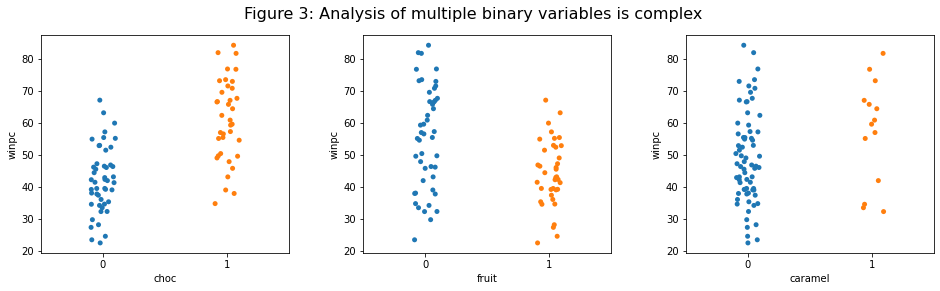

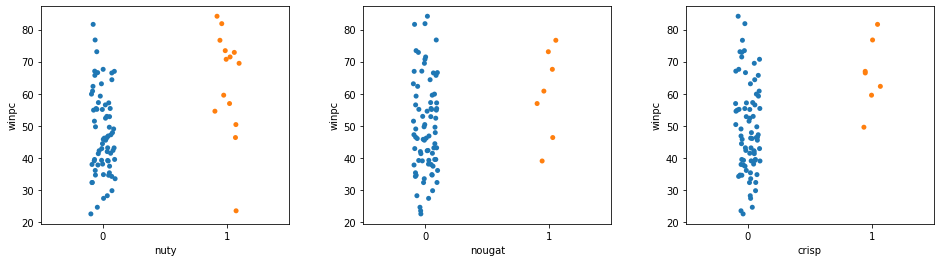

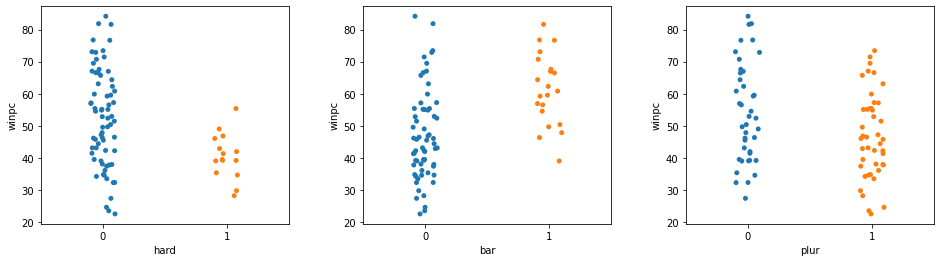

In [16]:
                                
fig3, ax1 = plt.subplots(nrows=1, ncols=3)
fig3.set_size_inches(16, 4)
plt.subplots_adjust(wspace=0.3)
    
sns.stripplot( x='choc', y='winpc', data = df, ax=ax1[0])
ax1[0].set_xlabel('choc')
ax1[0].set_ylabel('winpc')

sns.stripplot(x='fruit', y='winpc', data = df, ax=ax1[1])
ax1[1].set_xlabel('fruit')
ax1[1].set_ylabel('winpc')

sns.stripplot(x='caramel', y='winpc', data = df, ax=ax1[2])
ax1[2].set_xlabel('caramel')
ax1[2].set_ylabel('winpc')

fig4, ax4 = plt.subplots(nrows=1, ncols=3)
fig4.set_size_inches(16, 4)
plt.subplots_adjust(wspace=0.3)

sns.stripplot( x='nuty', y='winpc', data = df, ax=ax4[0])
ax4[0].set_xlabel('nuty')
ax4[0].set_ylabel('winpc')

sns.stripplot(x='nougat', y='winpc', data = df, ax=ax4[1])
ax4[1].set_xlabel('nougat')
ax4[1].set_ylabel('winpc')

sns.stripplot(x='crisp', y='winpc', data = df, ax=ax4[2])
ax4[2].set_xlabel('crisp')
ax4[2].set_ylabel('winpc')

fig5, ax5 = plt.subplots(nrows=1, ncols=3)
fig5.set_size_inches(16, 4)
plt.subplots_adjust(wspace=0.3)

sns.stripplot( x='hard', y='winpc', data = df, ax=ax5[0])
ax5[0].set_xlabel('hard')
ax5[0].set_ylabel('winpc')

sns.stripplot(x='bar', y='winpc', data = df, ax=ax5[1])
ax5[1].set_xlabel('bar')
ax5[1].set_ylabel('winpc')

sns.stripplot(x='plur', y='winpc', data = df, ax=ax5[2])
ax5[2].set_xlabel('plur')
ax5[2].set_ylabel('winpc')
    
fig3.suptitle('Figure 3: Analysis of multiple binary variables is complex\n', fontsize=16)
#plt.title('Figure 1: Scatterplots of continuous variables\n', fontsize=16)

plt.show()

In [17]:
# For statistics. Requires statsmodels 5.0 or more
from statsmodels.formula.api import ols
# Analysis of Variance (ANOVA) on linear models
from statsmodels.stats.anova import anova_lm

# Fit the model
model = ols("winpc ~ choc + fruit + caramel + nuty + nougat + crisp + hard + bar + plur", 
            df).fit()

# Print the summary
print(model.summary())

# print("\nRetrieving manually the coefficient estimates:")
# print(model._results.params)


# Peform analysis of variance on fitted linear model
# anova_results = anova_lm(model)

# print('\nANOVA results')
# print(anova_results)

plt.show()

                            OLS Regression Results                            
Dep. Variable:                  winpc   R-squared:                       0.515
Model:                            OLS   Adj. R-squared:                  0.457
Method:                 Least Squares   F-statistic:                     8.842
Date:                Fri, 15 Jan 2021   Prob (F-statistic):           6.05e-09
Time:                        09:12:47   Log-Likelihood:                -317.92
No. Observations:                  85   AIC:                             655.8
Df Residuals:                      75   BIC:                             680.3
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     35.0155      4.078      8.586      0.0

   
So this full model accounts for 51.5% of the variation in approval rating _winpc_.  
This is the same value that FiveThirtyEight reported.  

Note that the fitted coefficients are not equal to the difference in means of the groups.  This is because the linear model takes a weighted average based on group size.


 <center>  Table 1:  Variables that have least effect on the R-squared value</center>

| Variable | Effect on R-squared |  
| --- | --- |   
| carmel | drops from 0.515 to 0.509 |  
| nougat | drops from 0.509 to 0.506 |  
| hard   | drops from 0.506 to 0.493 |  
| bar    | drops from 0.493 to 0.492 |  
| plur   | stable at 0.492 |  

This suggests that the set of ingredients for a candy bar with greatest impact is:  
> _choc_ + _fruit_ + _nuty_ + _crisp_

They account for 49.2% of the variation in the approval rating.

However, the _crisp_ variable has a _p-value_ of 0.052 and the confidence interval contains zero.  So this variable was rejected.

So the final model contains three predictor variables.  This parsimonous model has the additional benefit of satisifying the sampling criterion.

In [28]:
# Fit the model
model = ols("winpc ~ choc + fruit + nuty ", 
            df).fit()
print(model.summary())

print("\n+ crisp + hardR-squared: : {:.3f}".format(model.rsquared))


                            OLS Regression Results                            
Dep. Variable:                  winpc   R-squared:                       0.467
Model:                            OLS   Adj. R-squared:                  0.448
Method:                 Least Squares   F-statistic:                     23.68
Date:                Fri, 15 Jan 2021   Prob (F-statistic):           4.21e-11
Time:                        10:00:55   Log-Likelihood:                -321.89
No. Observations:                  85   AIC:                             651.8
Df Residuals:                      81   BIC:                             661.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     35.7883      3.237     11.057      0.0

* Comparison with top ten candy bars

In [33]:
df.sort_values(by=['winpc'], ascending=False).head(10)

,brand,choc,fruit,caramel,nuty,nougat,crisp,hard,bar,plur,winpc
53,ReeseÕs Peanut Butter cup,1,0,0,1,0,0,0,0,0,84.180
52,ReeseÕs Miniatures,1,0,0,1,0,0,0,0,0,81.866
80,Twix,1,0,1,0,0,1,0,1,0,81.643
29,Kit Kat,1,0,0,0,0,1,0,1,0,76.769
65,Snickers,1,0,1,1,1,0,0,1,0,76.674
54,ReeseÕs pieces,1,0,0,1,0,0,0,0,1,73.435
37,Milky Way,1,0,1,0,1,0,0,1,0,73.100
55,ReeseÕs stuffed with pieces,1,0,0,1,0,0,0,0,0,72.888
33,Peanut butter M&MÕs,1,0,0,1,0,0,0,0,1,71.465
43,Nestle Butterfinger,1,0,0,1,0,0,0,1,0,70.736


It is likely that there are interactions between explanatory variables.  For instance, 7 out of the top 10 bars have the _choc_, _nuty_ combination.  However, to consider all nine predictors and interactions among these variables would result in a model so complex that it would impeed analysis. 

## Conclusion

To answer the primary research question of explanatory variables that contribute to most of the variance in the outcome, I conducted two primary tests: a simple linear regression and a multiple linear regression. 

Simple linear regression explored the effect of the _choc_ variable alone.  There was a positive step increase of 18.779 percentage points in the mean of the group with _choc_ compared to the reference level (mean of group without _choc_).  This increase was significant (t(36, p<0.05) = 7.519) indicating that inclusion of chocolate in a candy bar leads to increase in candy bar rating.  

Multiple linear regression examined the impact of all nine binary explanatory variables.  By observing the effect on the R-squared value when variables are omitted from the 9 variable model, I arrived at an optimal set of variables (_choc_, _fruit_, _nuty_).  Overall, the model was significant (F(3, 82)=23.68, p<.05), and could account for 46.7% of the variance in the outcome (Adjusted R2=44.8%). The best predictor of candy bar rating was 
_choc_ which could account for a unique proportion of variance in the outcome of 40.5%.


# Clustering

Clustering has use in both Exploratory Data Analysis and for Classification by unsupervised learning.  It involves finding natural groupings in the data.  Consider these groupings as areas of high density in the feature space.  It is a two step process.  The inductive step constructs a model of the groupings or clusters from training data.  Next the deductive step applies this model to test data in order to classify it as belonging to a particular grouping.   
![](./build-classification-model.jpeg)  
__Figure 4: Building a Classification Model__  
(Tan, Kumar and Steinbach, 2016)  

## K Nearest Neighbours
A test point that needs classification.  The KNN algorithm inspects the k points nearest to the test point.  It assigns a class to the test point based on the class of the k neighbours.  

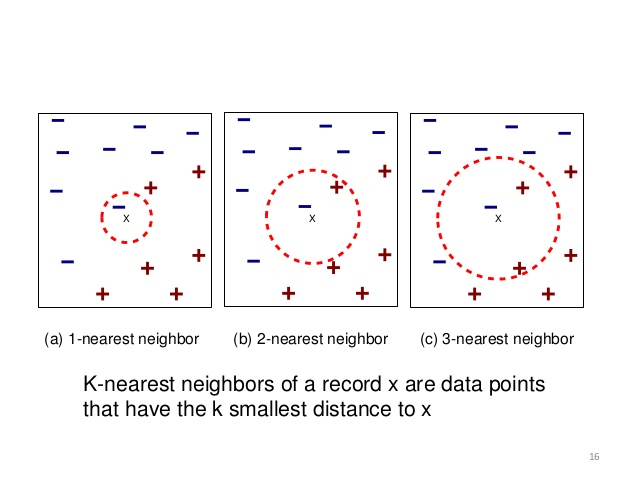

In [69]:
Image(filename='./knn-points.jpeg', width=500)

In the above example, when k = 1, the test point x gets assigned to the $-$ class.  In comparison, for k = 3, x gets the $+$ class.  This illustrates use of the majority scheme to determine similarity.  

In effect, K-nearest neighbours operates on the principle 
> If it looks like a duck and waddles like a duck and quacks like a duck  
> Then it is a duck

Choosing the value of k is a critical issue.  If it is too small, then the model will adapt to both signal and noise in the training data resulting in overfitting.  If it is too large, then the test point can be assigned to the class of those instances that are from away from it.  And so, there is underfitting.

A way to avoid underfitting is through the distance-weighted voting scheme.  In this case, instances that are close to x get a greater weighting than those far from x.

## Justification for KNN Classification
The primary advantages are 
* Ease of interpretation    
* Efficient compute time  

In addition,  
* Predictive power   
    It gets a 2 out of 3 rating for predictive power when compared with logistic regression, CART and Random Forest (Srivastava, 2018).

## Justification for the non-voters dataset
(Thomson-DeVeaux, Mithani and Bronner, 2020)  

* The response variable is categorical with three categories.  Thus it facilitates assessment of a multi-class classifier on a simple dataset (with only three classes).  
* Explanatory variables record response to political questions as discrete numerical data.  As a result, the algorithm can calculate similarity measures.

* This is an extensive dataset with 5,835 respondents (rows) and 33 questions.  Each question has as set of possible replies.  

* There is a codebook available that details each of the variables.


> <span style="color:darkblue">Primary Research Question:</span>  
> Is it possible to predict a person's voting intentions based on their views about
> political and social issues.  
> What proportion of correct predictions does the KNN algorithm make when applied to the _non-voters_ dataset?

__Initialisation__

In [21]:
from IPython.display import Image
from IPython.display import display 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [4]:
nv_df= pd.read_csv('./non-voters/nonvoters_data.csv')


## Exploratory Data Analysis


In [5]:
nv_df.head()

,RespId,weight,Q1,Q2_1,Q2_2,Q2_3,Q2_4,Q2_5,Q2_6,Q2_7,Q2_8,Q2_9,Q2_10,Q3_1,Q3_2,Q3_3,Q3_4,Q3_5,Q3_6,Q4_1,Q4_2,Q4_3,Q4_4,Q4_5,Q4_6,Q5,Q6,Q7,Q8_1,Q8_2,Q8_3,Q8_4,Q8_5,Q8_6,Q8_7,Q8_8,Q8_9,Q9_1,Q9_2,Q9_3,Q9_4,Q10_1,Q10_2,Q10_3,Q10_4,Q11_1,Q11_2,Q11_3,Q11_4,Q11_5,Q11_6,Q14,Q15,Q16,Q17_1,Q17_2,Q17_3,Q17_4,Q18_1,Q18_2,Q18_3,Q18_4,Q18_5,Q18_6,Q18_7,Q18_8,Q18_9,Q18_10,Q19_1,Q19_2,Q19_3,Q19_4,Q19_5,Q19_6,Q19_7,Q19_8,Q19_9,Q19_10,Q20,Q21,Q22,Q23,Q24,Q25,Q26,Q27_1,Q27_2,Q27_3,Q27_4,Q27_5,Q27_6,Q28_1,Q28_2,Q28_3,Q28_4,Q28_5,Q28_6,Q28_7,Q28_8,Q29_1,Q29_2,Q29_3,Q29_4,Q29_5,Q29_6,Q29_7,Q29_8,Q29_9,Q29_10,Q30,Q31,Q32,Q33,ppage,educ,race,gender,income_cat,voter_category
0,470001,0.752,1,1,1,2,4,1,4,2,2,4,2,1,1,4,4,3,2,2,1,2,2,2,2,1,2,1,3,4,2,1,1,1,1,2,4,2,2,4,4,2,2,2,2,2,2,2,2,2,2,5,1,1,1,1,1,3,2,2,2,2,2,2,2,2,2,2,-1,-1,1,1,1,1,1,-1,-1,-1,1,1,NaN,2,1,1,1,1,1,1,1,1,1,1.0,1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,1.0,NaN,73,College,White,Female,$75-125k,always
1,470002,1.027,1,1,2,2,3,1,1,2,1,1,3,3,3,4,3,3,2,2,2,2,3,3,1,1,2,2,2,3,2,2,2,2,3,2,2,1,1,3,4,2,2,2,2,2,2,1,2,2,2,1,1,2,2,2,2,3,2,2,2,2,2,2,2,2,2,2,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,1,1,NaN,1,3,3,1,1,1,1,1,1,1,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,NaN,NaN,1.0,90,College,White,Female,$125k or more,always
2,470003,1.084,1,1,1,2,2,1,1,2,1,4,3,2,2,3,3,2,2,2,2,3,3,2,3,1,1,1,3,2,1,1,2,2,2,2,1,1,2,4,4,2,2,1,2,2,2,1,2,1,2,5,2,1,1,3,1,1,2,2,2,2,2,2,1,2,2,2,-1,1,-1,1,-1,-1,-1,1,1,-1,1,1,NaN,2,1,2,1,1,1,1,1,1,1,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,2.0,NaN,53,College,White,Male,$125k or more,sporadic
3,470007,0.682,1,1,1,1,3,1,1,1,1,1,2,1,1,4,4,2,1,1,2,2,2,2,2,1,3,1,3,2,2,2,2,2,2,2,2,1,2,4,4,2,2,2,2,1,2,2,2,1,2,5,1,4,1,1,1,1,2,2,2,2,2,2,2,2,2,2,-1,-1,1,-1,-1,-1,-1,1,-1,1,1,1,NaN,2,1,2,1,1,1,1,1,1,1,1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,1.0,NaN,58,Some college,Black,Female,$40-75k,sporadic
4,480008,0.991,1,1,1,-1,1,1,1,1,1,1,1,4,-1,1,1,2,4,1,1,1,1,1,1,1,2,2,1,3,2,3,3,3,4,2,2,1,4,3,4,2,2,2,2,2,2,1,2,2,2,1,5,1,2,2,4,4,2,2,2,2,2,2,2,2,2,2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,1,NaN,1,3,1,1,1,1,1,1,1,1,1.0,1.0,1.0,-1.0,1.0,-1.0,1.0,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,-1.0,NaN,NaN,81,High school or less,White,Male,$40-75k,always


Since young Blacks and Hispanics were over-represented in the study, there is a weighting in order to proportion respondents according to general population benchmarks for US citizens.  
(Wolfe, 2020)

In [37]:
nv_df.shape

(5836, 119)

In [6]:
# Select only columns for questions, weighting and outcome (voter_category)
features = nv_df.iloc[:, 1:113]

# Check for missing values:
drop_list = features.columns[features.isna().any()].tolist()
features = features.drop(drop_list, axis = 1)
features.columns[features.isna().any()].tolist()
# empty list means that there are no 'NaN's remaining

[]

In [7]:
# Select values as nd arrays
feature_v = features.values
target = nv_df["voter_category"]

The following procedures are those recommended by Purva Huilgol (Huilgol, 2020). 

### Distribution of the response variable
Of the elections that the respondents were eligible to vote in, their categories are:
* Always: Voted on all or all bar one  
* Sporadic: Voted in at least two but less than all bar one  
* Rarely/Never: Voted on 0 or 1 election

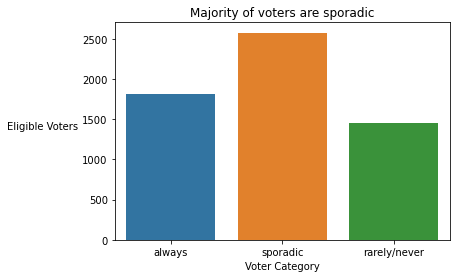

Voter category strata: 


sporadic        0.441
always          0.310
rarely/never    0.249
Name: voter_category, dtype: float64

In [8]:
sns.countplot(target)

# Add labels
plt.title('Majority of voters are sporadic')
plt.xlabel('Voter Category')
# ha - horizontal alignment
plt.ylabel('Eligible Voters',rotation='horizontal', ha='right')
plt.show()

print("Voter category strata: ")
nv_df['voter_category'].value_counts()/len(nv_df)

## K-Nearest Neighbour Classifier model

__Scaling__

In [9]:
np.random.seed(123)
#Scaling - mandatory for knn
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
features = ss.fit_transform(features)

__Split into training and test datasets__  
70% training and 30% test

In [10]:
X_train, X_test, y_train, y_test = train_test_split(features, target,
                                                    test_size=0.30,
                                                    shuffle=False,
                                                    random_state=4) 

In [11]:
# Verify the proportional split into train and test
print("Ratio of X train to test: {:.3f}".format(len(X_train)/len(X_test)) )
print("Ratio of y train to test: {:.3f}".format(len(y_train)/len(y_test)) )


Ratio of X train to test: 2.333
Ratio of y train to test: 2.333


__Stratification__  
Verify that there is the same stratification as in the source data.

In [12]:
unique_train, counts_train = np.unique(y_train, return_counts=True)
print("Voter category strata (train):")
strata_train = np.asarray((unique_train, np.round(counts_train/len(y_train), 3))) 
print(strata_train )

unique_test, counts_test = np.unique(y_test, return_counts=True)
print("\nVoter category strata (test):")
strata_test = np.asarray((unique_test, 
                          np.round(counts_test/len(y_test), 3)) )
print(strata_test )

Voter category strata (train):
[['always' 'rarely/never' 'sporadic']
 [0.337 0.219 0.444]]

Voter category strata (test):
[['always' 'rarely/never' 'sporadic']
 [0.248 0.317 0.435]]


### k value

The following code to determine the k-value uses the `knn.score()` method and selects the one with the highest score.  

In [24]:
train_score = []
test_score = []
k_vals = []

# Calculate scores for k values from 1 to 20
for k in range(1, 21):
    k_vals.append(k)
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train)
    
    tr_score = knn.score(X_train, y_train)
    train_score.append(tr_score)
    
    te_score = knn.score(X_test, y_test)
    test_score.append(te_score)
    
## score that comes from the testing set only
max_test_score = max(test_score)
test_scores_ind = [i for i, v in enumerate(test_score) 
                   if v == max_test_score]
print('Max test score {:.5f} and k = {}'.format(max_test_score * 100, 
                                            list(map(lambda x: x + 1, 
                                                     test_scores_ind))))

Max test score 51.05654 and k = [17, 18]


In [13]:
#Setup a knn classifier with k neighbors
knn = KNeighborsClassifier(17)

knn.fit(X_train, y_train)
print('Accuracy: {:.5f}'.format( knn.score(X_test, y_test) ) )

Accuracy: 0.51057


In [14]:
y_pred = knn.predict(X_test)
confusion_matrix(y_test, y_pred)
test_ct = pd.crosstab(y_test, y_pred, 
            rownames = ['Actual'], 
            colnames =['Predicted'], 
            margins = True)

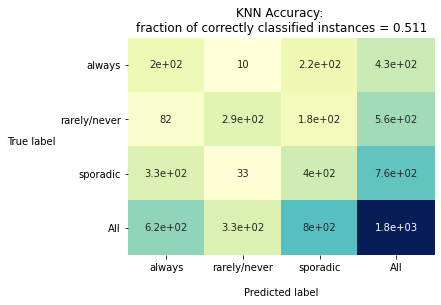

In [15]:
confusion = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(confusion)

plt.figure(figsize = (5.5, 4))
sns.heatmap(test_ct, cmap="YlGnBu", annot=True, cbar=False) 

#sns.heatmap(confusion, annot = True)
plt.title("KNN Accuracy: \nfraction of correctly classified instances = {0:.3f}"
         .format(accuracy_score(y_test, y_pred)))
plt.ylabel('True label', rotation='horizontal', ha='right')
plt.xlabel('\nPredicted label')
plt.show()

There are many miss-classifications.  For instance, the _sporadic_ class is predicted (incorrectly) to be _always_ and this occurs in 330 instances.   
So the low level of overall accuracy (0.511) is not surprising.  It is likely that the source data needs further refinement. 

## Evaluation Metrics  
    1. Accuracy  
    2. Precision  
    3. Recall  
    4. F1-Score  
    
### 1. Accuracy
For a binary classifier: 
> Accuracy is the ratio of the total number of correct predictions and  
> the total number of instances.  

$$ Accuracy = \frac{TP + TN}{TP + FP + TN + FN}$$

### 2. Precision

> Precision is the ratio between the True Positives and   
> all the Positives. 

Mathematically:  
$$ Precision = \frac{TP}{TP + FP}$$

`Precision` also gives a measure of the data points that are relevant. We do not want to put a voter into the _always_ class when they are either in the _sporadic_ or _never_ class.

For example, the precision for the _always_ class is  
$$\frac{204}{204 + 82 + 329} = 0.332$$

### 3. Recall
The recall is the measure of the model correctly identifying True Positives. Thus, for the three voter classes, `recall` gives the proportion of instances that the model identified correctly.  
Mathematically:  
$$ Recall = \frac{TP}{TP + FN}$$

For a binary classifier, this is the __Sensitivity__ or True Positive Rate. What if the model predicted that an _always_ voter is in the _never_ class and so, no ballot was sent to that voter.

The `recall` for the _never_ class is
$$ \frac{290}{290 + 82 + 180} = 0.525$$

In situations where it is critical that a class is identified correctly, as in medicine, the classifier needs to have high `recall`. 

`Precision` aims to minimise false positives.  If we need to avoid incorrectly classifying patients as _covid_ positive,  we should aim for high precision.  As a result, resources go to those patients that need them and not to the _false positives_. 

Ideally, the model should have high precision and high recall values.  However, it is not possible to achieve both goals at the same time.  If there is high `recall` and critical patients get the care that they need, there will also be patients treated who do not need it.

In contrast, if there is high `precision`, this avoids giving treatment to those who do not need it.  However, in this case, there will be patients going without the treatment that they require.

### 4. F1-Score
From the above discussion, it is clear that there is a tradeoff between Precision and Recall. The context for applying a classifier informs which metric to emphasise.

* For example, for the _non-voter_ dataset, a polling company needs to identify the correct class for each voter and they aim for high recall / sensitivity.

* A political campaign may want to avoid putting a voter in the incorrect class so that they can target relevant voters.  So the model should have high precision.

* In other situations, a campaign manager could decide that they need to have voters identified correctly and to avoid incorrect classifications.

The F1-score is a way to deal with the Precision / Recall tradeoff.  The F1-score is the Harmonic mean of the Precision and Recall:

$$ F1Score = 2 \times \frac{Precision * Recall}{Precision + Recall}$$

As a result, by aiming for a good F1-score, it is not necessary to balance over and back between Precision and Recall.  A high F1-score indicates a good Precision and a good Recall value as well.

__Classification Report__    
* Evaluation metrics for each class  
* Accuracy averaged over all classes

In [62]:
print(classification_report(y_test, y_pred))
print('support refers to the number of instances in each class')

              precision    recall  f1-score   support

      always       0.33      0.47      0.39       434
rarely/never       0.87      0.52      0.65       555
    sporadic       0.50      0.52      0.51       762

    accuracy                           0.51      1751
   macro avg       0.57      0.51      0.52      1751
weighted avg       0.58      0.51      0.53      1751

support refers to the number of instances in each class


## Multi-Class Evaluation
(Collins-Thompson, 2020)  

* an extension of binary classification 
    - each class has a true or false prediction
* The overall evaluation metrics are _averages_ across all classes
    - Micro-average
    - Macro-average

In [76]:
d = {'Class': ['orange', 'orange', 'orange', 'orange', 'orange', 'lemon', 'lemon', 'apple', 'apple'], 
     'Predicted': ['lemon', 'lemon', 'apple', 'orange', 'apple', 'lemon', 'apple', 'apple', 'apple'], 
    'Correct': [0, 0, 0, 1, 0, 1, 0, 1, 1]}
fruit = pd.DataFrame(d )

display(fruit)

,Class,Predicted,Correct
0,orange,lemon,0
1,orange,lemon,0
2,orange,apple,0
3,orange,orange,1
4,orange,apple,0
5,lemon,lemon,1
6,lemon,apple,0
7,apple,apple,1
8,apple,apple,1


* Macro-average  
    - each class has equal weight  
    - macro-average precision:  
        - (1/5 + 1/2 + 2/2) / 3 = 0.57  
* Micro-average
    - each instance has equal weight
    - micro-average precision
        - 4/9 = 0.44 

__Micro-averaged Vs Macro-averaged Precision__


In [25]:
print('\nMicro-averaged precision = {:.2f} (treat instances equally)'
      .format(precision_score(y_test, y_pred, average = 'micro')))
print('Macro-averaged precision = {:.2f} (treat classes equally)'
      .format(precision_score(y_test, y_pred, average = 'macro')))

print('\nMicro-averaged recall = {:.2f} (treat instances equally)'
      .format(recall_score(y_test, y_pred, average = 'micro')))
print('Macro-averaged recall = {:.2f} (treat classes equally)'
      .format(recall_score(y_test, y_pred, average = 'macro')))


Micro-averaged precision = 0.51 (treat instances equally)
Macro-averaged precision = 0.57 (treat classes equally)

Micro-averaged recall = 0.51 (treat instances equally)
Macro-averaged recall = 0.51 (treat classes equally)


It is expected that micro- and macro-averaged precision will be close when there are about the same number of instances in each class.


## Conclusions

As noted, there is a low level of overall accuracy (0.511).  This means that there is equal likelihood of the model making a correct prediction as for giving an incorrect prediction.  So this multi-class classifier provides no information.

As for the question on the suitability of social and political survey data, it is likely that the source data needs further refinement.

# References

Assumptions of Linear Regression (2021) Statistics Solutions. Available at: https://www.statisticssolutions.com/assumptions-of-linear-regression/ (Accessed: 9 January 2021).

Collins-Thompson, K. (2020) Multi-Class Evaluation. University of Michigan, Coursera. Available at: https://www.coursera.org/learn/python-machine-learning/lecture/1ugJR/multi-class-evaluation (Accessed: 19 January 2021).

Hickey, W. (2017) The Ultimate Halloween Candy Power Ranking. FiveThirtyEight. Available at: https://fivethirtyeight.com/videos/the-ultimate-halloween-candy-power-ranking/ (Accessed: 13 January 2021).  

Huilgol, P. (2020) Precision vs Recall - An Intuitive Guide for Every Machine Learning Person. Analytics Vidhya. Available at: https://www.analyticsvidhya.com/blog/2020/09/precision-recall-machine-learning/ (Accessed: 18 January 2021).

Irizarry, R. (2018) Introduction to Linear Models and Matrix Algebra, PH525.2x, edX. Harvard Life Sciences. Available at: https://courses.edx.org/courses/course-v1:HarvardX+PH525.2x+2T2017/course/ (Accessed: 11 January 2021).

Simple Linear Regression (2016) Boston University School of Public Health. Available at: https://sphweb.bumc.bu.edu/otlt/MPH-Modules/BS/R/R5_Correlation-Regression/R5_Correlation-Regression4.html (Accessed: 9 January 2021).

Srivastava, T. (2018) Introduction to k-Nearest Neighbors: A powerful Machine Learning Algorithm (with implementation in Python & R). Analytics Vidhya. Available at: https://www.analyticsvidhya.com/blog/2018/03/introduction-k-neighbours-algorithm-clustering/ (Accessed: 16 January 2021).

Tan, P., Kumar, V. and Steinbach, M. (2016) Introduction To Data Mining. 4th edn. Pearson.

Thomson-DeVeaux, A., Mithani, J. and Bronner, L. (2020) Why Millions Of Americans Don’t Vote. FiveThirtyEight. Available at: https://projects.fivethirtyeight.com/non-voters-poll-2020-election/ (Accessed: 18 January 2021).

Wolfe, J. (2020) fivethirtyeight/data/non-voters/README.md. github. Available at: https://github.com/fivethirtyeight/data/tree/master/non-voters (Accessed: 18 January 2021).